In [1]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [36]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_precursor_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [37]:
# load and check the search space
from stk_search import Search_space
search_space = pd.read_pickle(search_space_loc)
print(' Search space condition list:', search_space.conditions_list)
print('shape of df_precursors:', search_space.df_precursors.shape)
print('search space syntax:', search_space.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (274, 49)
search space syntax: [0, 1, 2, 3, 4, 5]


In [39]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark , df_precursors= database_utils.load_data_from_file(df_total_path_bench, df_precursor_path,add_feature_frag=True)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
print('shape of df_Benchmark:', df_Benchmark.shape)
print('shape of df_precursors:', df_precursors.shape)
print('shape of df_precursor_Mordred:', df_precursor_Mordred.shape)
print(df_Benchmark[df_Benchmark['target']>0].shape[0]/df_Benchmark.shape[0])

shape of df_Benchmark: (30000, 207)
shape of df_precursors: (306, 40)
shape of df_precursor_Mordred: (312, 101)
0.0111


In [40]:
num_of_elem_in_SP = search_space.check_df_for_element_from_SP(df_Benchmark).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)

number of elements in the benchmark in the search space: (30000, 207)


In [101]:
# set the benchmark parameters  
exp_name = "Benchmark_56K_dataset"
num_elem_initialisation=50
num_iteration=500
target = 'target'
aim = 'maximise'
case_name_list = ["ea_surrogate_new", "BO_learned_new"] # ['evolution_algorithm','random','BO_precursor']#,["ea_surrogate_new", "BO_learned_new"] # "ea_surrogate", "BO_learned"
config_dir_list = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000"]
config_dir_list_new = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240412/SchNet/splitrand-nummol68864"]
config_dir_list_new = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/"]#f"/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240513/SchNet/splitrand-nummol{num_mol}" for num_mol in [10000,20000,30000,40000,50000]]

In [25]:
# check the representation generated using the learned representation ( using a gnn for each fragment)
config_dir = config_dir_list[0]
from src.dev_scripts.run_search_new import load_representation_BO_graph_frag
representation = load_representation_BO_graph_frag(config_dir,df_total_path)
representation.generate_repr(df_Benchmark[[f'InChIKey_{i}' for i in range(6)]].loc[0:100,:])

config loaded from /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000
/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322//SchNet/splitrand-nummol50000//transformer/epoch=43-val_loss=0.42-other_metric=0.00.ckpt
no dataset found
Model loaded:  /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000/epoch=18-val_loss=0.21-other_metric=0.00.ckpt
lr 0.0005
loading model from checkpoint /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322//SchNet/splitrand-nummol50000//transformer/epoch=43-val_loss=0.42-other_metric=0.00.ckpt


tensor([[-0.2190, -0.8119, -0.2114,  ...,  1.2795, -1.1144, -0.6874],
        [-0.3359, -0.7804, -0.1105,  ...,  1.2327, -1.1164, -0.6467],
        [-0.2828, -0.6610, -0.1364,  ...,  0.9725, -0.9670, -0.6088],
        ...,
        [ 0.2659,  0.0685, -0.2045,  ...,  0.4034, -1.1325,  0.4292],
        [-0.7570, -0.6297,  0.0800,  ...,  0.9786, -1.2912, -0.7561],
        [ 0.2412,  0.1611, -0.3039,  ...,  0.2308, -0.8912,  0.3342]])

In [98]:
# check the representation generated using the learned representation building the polymer from fragment for 
config_dir = config_dir_list_new[0]
from src.dev_scripts.run_search_new import load_representation_model
representation, pymodel = load_representation_model(config_dir)
representation.generate_repr(df_Benchmark[[f'InChIKey_{i}' for i in range(6)]].loc[0:100,:])

config loaded from /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [102]:
importlib.reload(run_hpc_utils)

def run_search_on_hpc(
    case_name="ea_surrogate",
    df_path_total=df_total_path_bench,
    df_precursors_path=df_precursor_path,
    frag_properties="selected",
    config_dir="",
    dataset_representation_path = None,
    test=False,
    lim_counter = 5,
    which_acquisition = "EI",

):
    string_to_run_notebook, script_qsub = run_hpc_utils.generate_string_run(
        case=case_name,
        target=target,
        aim=aim,
        num_elem_initialisation=num_elem_initialisation,
        num_iteration=num_iteration,
        df_path=df_path_total,
        benchmark=True,
        test_name=exp_name,
        df_precursors_path=df_precursors_path,
        frag_properties=frag_properties,
        config_dir=config_dir,
        dataset_representation_path=dataset_representation_path,
        lim_counter = lim_counter,
        which_acquisition = which_acquisition,
        search_space_loc = search_space_loc,
    )
    if test:
        %run {string_to_run_notebook}
        return string_to_run_notebook
    run_hpc_utils.submit_job(script_qsub, case_name)




In [103]:
for case_name in case_name_list:
    if case_name == 'ea_surrogate' or case_name == "BO_learned":
        for config_dir in config_dir_list:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    elif case_name == 'ea_surrogate_new' or case_name == "BO_learned_new":
        for config_dir in config_dir_list_new:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    else:
        run_search_on_hpc(
            case_name=case_name,
            df_precursors_path=df_precursor_path,
            frag_properties="selected",
        )
        if case_name =='BO_precursor':
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_Mordred_path,
                frag_properties="all",
        )

src/dev_scripts/run_search_new.py  --case ea_surrogate_new --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --config_dir /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/ --search_space_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl --frag_properties selected --lim_counter 5


9435038[].pbs
src/dev_scripts/run_search_new.py  --case BO_learned_new --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --config_dir /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/ --search_space_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl --frag_properties selected --lim_counter 5
9435039[].pbs


In [46]:
run_search_on_hpc(
                case_name='BO_precursor',
                df_precursors_path=df_precursor_Mordred_path,
                frag_properties="all",
        )

src/dev_scripts/run_search_new.py  --case BO_precursor --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl --search_space_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl --frag_properties all --lim_counter 5
9434379[].pbs


# load results and plot some metrics

In [115]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
df = df[df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(2399, 21)


,num_iteration,num_elem_initialisation,test_name,case,target_name,config_dir,aim,which_acquisition,lim_counter,search_space_loc,...,df_path,df_precursors_path,benchmark,dataset_representation_path,frag_properties,run_search_name,search_output_folder,date,git_version,search_exp_file
0,500,50,Benchmark_56K_dataset,BO_precursor,target,,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Full_dataset/30K_benchmark_150524.csv,data/output/Prescursor_data/precursor_data_200...,True,None,selected,a7ebd9293ec84c7c8e118bfb8b1c234e,data/output/search_experiment/6_frag/Benchmark...,20240516,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/Benchmark...
1,300,50,new_target,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,ac97e57ea5cf4449a242bc02251a0e62,data/output/search_experiment/6_frag/new_target,20240323,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/new_targe...
2,300,50,frag_prop,BO_precursor,target,/rds/general/user/ma11115/home/STK_Search/STK_...,0.0,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,/rds/general/user/ma11115/home/STK_Search/STK_...,True,/rds/general/user/ma11115/home/STK_Search/STK_...,all,ddb27e04633545739bbfadba54b279e3,data/output/search_experiment/6_frag/frag_prop,20240308,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/frag_prop...
3,500,50,Benchmark_75K_dataset,ea_surrogate_new,target,/rds/general/user/ma11115/home/STK_Search/STK_...,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Full_dataset/New_target07052024.csv,data/output/Prescursor_data/precursor_data_200...,True,None,selected,29aa2aea54e243ac9ca7f0a302160199,data/output/search_experiment/6_frag/Benchmark...,20240512,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/Benchmark...
4,300,50,different_representations_dataset,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,cf384899f2ed49d298302d960a2352c7,data/output/search_experiment/6_frag/different...,20240322,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/different...


In [116]:
num_iteration = 500
num_elem_initialisation = 50
oligomer_size = 6 
search_space_loc = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl'
df_filtered = df_all[df_all['num_iteration']==num_iteration]
df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_filtered[df_filtered['df_path']==df_total_path_bench]

df_filtered = df_filtered[df_filtered['oligomer_size']==oligomer_size]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir','df_path','df_precursors_path'])
print(len(df_list))
df_list.describe()

(350, 21)
(350, 21)
7


num_iteration  \
                                                                                                                                                                                                                      count   
case                frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                                 
BO_learned_new      selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...          50.0   
BO_precursor        all             EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv /rds/general/user/ma11115/home/STK_Search/STK_s...          50.0   
                                                                                                                                                           data/output/Prescursor_data/df_PCA_mordred_desc...          50.0   
                    selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...          50.0   
ea_surrogate_new    selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...          50.0   
evolution_algorithm selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...          50.0   
random              selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...          50.0   

                                                                                                                                                                                                                      \
                                                                                                                                                                                                                mean   
case                frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                          
BO_learned_new      selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...  500.0   
BO_precursor        all             EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv /rds/general/user/ma11115/home/STK_Search/STK_s...  500.0   
                                                                                                                                                           data/output/Prescursor_data/df_PCA_mordred_desc...  500.0   
                    selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...  500.0   
ea_surrogate_new    selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...  500.0   
evolution_algorithm selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003...  500.0   
random              selected   

In [121]:
import pandas as pd
def join_name(x):
    return '*'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 500
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('*')[0])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])

df_summary_1['which_acquisition'] = df_summary_1['key'].apply(lambda x: x.split('*')[2])
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,which_acquisition
0,BO_learned_new*selected*EI*/rds/general/user/m...,23,data/output/Full_dataset/30K_benchmark_150524.csv,BO_learned_new*selected*EI*/rds/general/user/m...,BO_learned_new,20000/*data/output/Full_dataset/30K_benchmark_...,EI
1,BO_precursor*all*EI**data/output/Full_dataset/...,36,data/output/Full_dataset/30K_benchmark_150524.csv,BO_precursor*all*EI**data/output/Full_dataset/...,BO_precursor,BO_precursor*all*EI**data/output/Full_dataset/...,EI
2,BO_precursor*selected*EI**data/output/Full_dat...,41,data/output/Full_dataset/30K_benchmark_150524.csv,BO_precursor*selected*EI**data/output/Full_dat...,BO_precursor,BO_precursor*selected*EI**data/output/Full_dat...,EI
3,ea_surrogate_new*selected*EI*/rds/general/user...,25,data/output/Full_dataset/30K_benchmark_150524.csv,ea_surrogate_new*selected*EI*/rds/general/user...,ea_surrogate_new,20000/*data/output/Full_dataset/30K_benchmark_...,EI
4,evolution_algorithm*selected*EI**data/output/F...,24,data/output/Full_dataset/30K_benchmark_150524.csv,evolution_algorithm*selected*EI**data/output/F...,evolution_algorithm,evolution_algorithm*selected*EI**data/output/F...,EI
5,random*selected*EI**data/output/Full_dataset/3...,50,data/output/Full_dataset/30K_benchmark_150524.csv,random*selected*EI**data/output/Full_dataset/3...,random,random*selected*EI**data/output/Full_dataset/3...,EI


In [122]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_all_y_max,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

 keys : 0    BO_learned_new*selected*EI*/rds/general/user/m...
1    BO_precursor*all*EI**data/output/Full_dataset/...
2    BO_precursor*selected*EI**data/output/Full_dat...
3    ea_surrogate_new*selected*EI*/rds/general/user...
4    evolution_algorithm*selected*EI**data/output/F...
5    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


len of mol_dataset 58501


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/tmp/pbs.9434319.pbs/ipykernel_1707788/2049536016.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[4].set_xticklabels([0,50,100,150,200,250,300,350])
/var/tmp/pbs.9434319.pbs/ipykernel_1707788/2049536016.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[5].set_xticklabels([0,50,100,150,200,250,300,350])


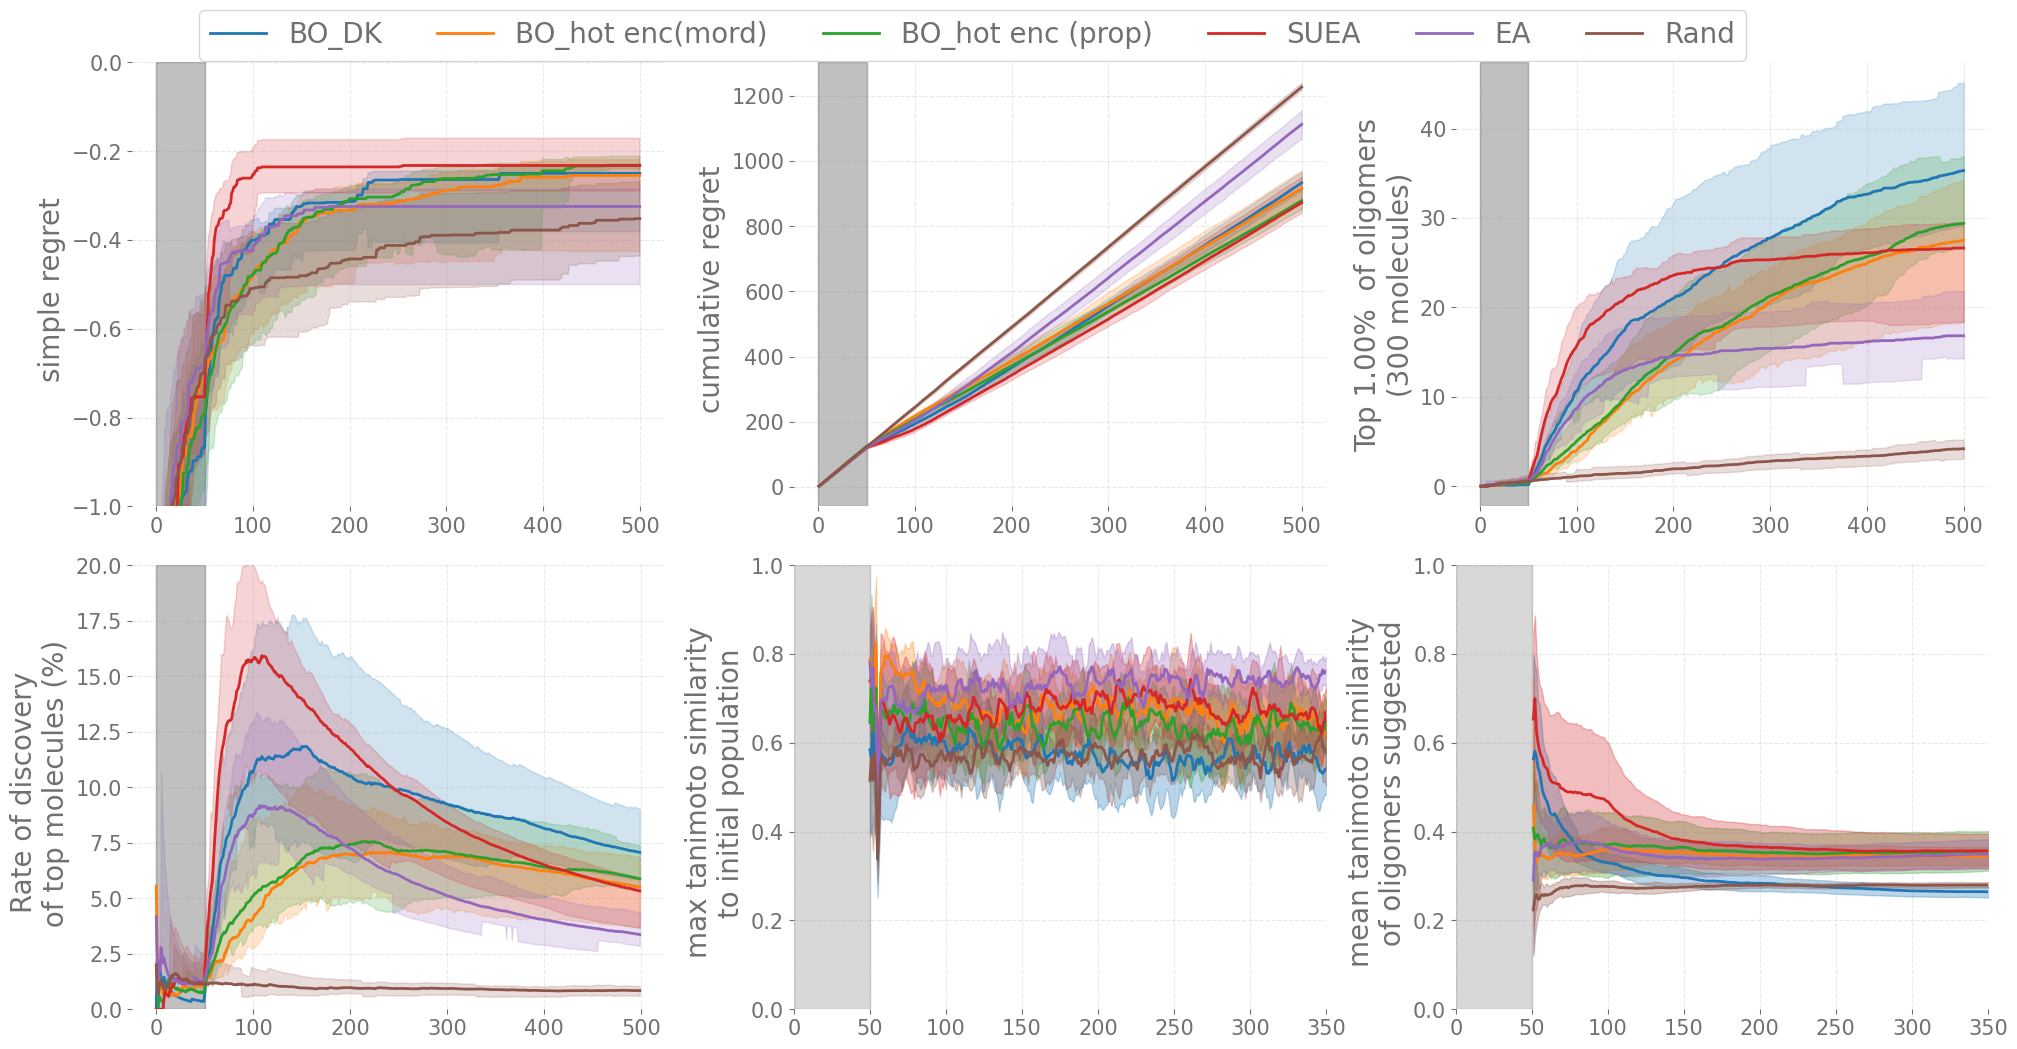

In [123]:
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot#.iloc[[0,1,2,3,4,5,6]]
legend_list = ['BO_DK', 'BO_hot enc(mord)','BO_hot enc (prop)','SUEA','EA','Rand']#'BO_DK','BO_DK new','SU EA','SU_EA New'


fig, axes,metric_dict_res = plot_results_all.plot_metric(df_plot,plot_function_list_single,results_dict,df_list,nb_iterations=min_num_iteration)
df_mol_dict = plot_results_all.add_similarity_plots(axes,df_plot,df_mol_dict,results_dict, nb_iterations=min_num_iteration-50,  nb_initialisation=50)
plot_results_all.save_mol_dict(df_mol_dict)
for ax_ in axes:
    ax_.set_xlabel('')

# update the axes geometry information
from matplotlib import gridspec
gs = gridspec.GridSpec(len(fig.axes), 3)
fig.set_size_inches(20, 30)
for i, ax in enumerate(fig.axes):
    ax.set_subplotspec(gs[i])
# set font size
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
# hide legend
axes[0].legend().set_visible(False)
fig.tight_layout()
lg = axes[0].legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), ncol=6,fontsize=20)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

axes[4].set_xlim(0,350)
axes[5].set_xlim(0,350)
axes[0].set_ylim(-1,0)
axes[3].set_ylim(0,20)
# rename x ticks
#axes[0].set_xticks([0,50,100,150,200,250,300,350])
axes[4].set_xticklabels([0,50,100,150,200,250,300,350])
axes[5].set_xticklabels([0,50,100,150,200,250,300,350])
axes[4].axvspan(0, 50, alpha=0.3, color="grey")
axes[5].axvspan(0, 50, alpha=0.3, color="grey")


fig_name = 'benchmarking_all_search_alg'
os.makedirs(save_folder,exist_ok=True)
pickle.dump(fig, open(save_folder+f'/{fig_name}.pkl','wb'))


In [124]:
df_mol_dict = plot_results_all.load_mol_dict()
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot#.iloc[[0,1,2,3,4,5,6]]
legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']


fig, axes,metric_dict_res = plot_results_all.plot_metric(df_plot,plot_function_list_multi,results_dict,df_list,nb_iterations=min_num_iteration)
axes[0].legend().set_visible(False)
fig.tight_layout()

axes[0].set_ylim(-1,1)
# delete axes in the second row
for _ax  in axes[3:]:
    _ax.set_visible(False)
from matplotlib import gridspec
gs = gridspec.GridSpec(len(fig.axes), 3)
fig.set_size_inches(20, 15)
lg = axes[0].legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), ncol=6,fontsize=20)
for i in range(len(legend_list)):
    lg.texts[i].set_text(legend_list[i])

In [86]:
max([max(x['ids_acquired']) for x in res])

549